In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_lfw_people

In [ ]:
faces = fetch_lfw_people(resize=0.4,min_faces_per_person=70)

In [108]:
data = faces.data
target = faces.target
names = faces.target_names

print("一共有{}条数据,特征数量是{}，一共有{}人，分别是{}".format(data.shape[0],data.shape[1],len(Series(target).unique()),names))

一共有1217条数据,特征数量是1850，一共有6人，分别是['Sharon' 'Powell' 'Rumsfeld' 'Bush' 'Schroeder' 'Blair']


In [19]:
target

array([3, 1, 0, ..., 5, 3, 5], dtype=int64)

In [109]:
# 因为特征数量太大，可以考虑降维处理
# 不涉及到分类参考，所以可以使用pca
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
train = pca.fit_transform(data)
train.shape

(1217, 75)

In [20]:
# 集成学习
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

estimators = []

model1 = LogisticRegression()
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier()
model4 = SVC()

estimators.append(("LogisticRegression",model1))
estimators.append(("KNeighborsClassifier",model2))
estimators.append(("DecisionTreeClassifier",model3))
estimators.append(("SVC",model4))

# 生成算法集成对象
enstimator = VotingClassifier(estimators)

# 交叉验证(选择一个更加稳定的算法、其次看算法评分)
kfold = KFold(n_splits=10)

results = cross_val_score(enstimator,train,target,cv=kfold)

In [22]:
results.mean(),results.std()

(0.6860791220701802, 0.03161725060945871)

In [27]:
enstimator.get_params

<bound method VotingClassifier.get_params of VotingClassifier(estimators=[('LogisticRegression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)>

In [33]:
# 使用svc测量
result1 = cross_val_score(SVC(kernel='linear'),train,target,cv=kfold)

In [34]:
# 使用logistic测量
result2 = cross_val_score(LogisticRegression(),train,target,cv=kfold)

In [31]:
# 使用knn测量
cross_val_score(KNeighborsClassifier(),train,target,cv=kfold)

array([0.63114754, 0.63114754, 0.59016393, 0.66393443, 0.60655738,
       0.59016393, 0.6147541 , 0.5785124 , 0.6446281 , 0.57024793])

In [32]:
# 使用决策树测量
cross_val_score(DecisionTreeClassifier(),train,target,cv=kfold)

array([0.49180328, 0.51639344, 0.54098361, 0.53278689, 0.46721311,
       0.45901639, 0.39344262, 0.47107438, 0.47933884, 0.50413223])

In [37]:
# 通过比较可以选择logistic或者svc进行测量
# 对比logistci和svc哪一个更稳定
print("方差比--SVC:{} Logistic:{}".format(result1.std(),result2.std()))
print("平均分--SVC:{} Logistic:{}".format(result1.mean(),result2.mean()))

# 最终选择Logistic回归

方差比--SVC:0.03715606616135987 Logistic:0.03189263991204182
平均分--SVC:0.7691437474596938 Logistic:0.8356862213792169


In [40]:
# 使用网格搜索找到最优参数
from sklearn.model_selection import GridSearchCV

param_dic = {
    'C':[0.00001,0.001,0.1,10,100,1000,10000],
    'penalty':['l1','l2']
}

logistic = LogisticRegression()
result = GridSearchCV(logistic,param_grid=param_dic)

In [41]:
result

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
# 拆分数据集
from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(train,target,random_state=1)
# 考虑到要展示预测结果，所以样本集的拆分，采用有序的方式进行
X_train = train[:1100]
y_train = target[:1100]
X_test = train[1100:]
y_test = target[1100:]

In [58]:
result.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
best_logistic = result.best_estimator_

In [60]:
# 使用最好的模型来进行预测，查看评分
best_logistic.score(X_test,y_test)

0.8376068376068376

In [61]:
# 查看人脸图片
data.shape

(1217, 1850)

In [49]:
faces.images.shape

(1217, 50, 37)

Text(0.5,1,'George W Bush')

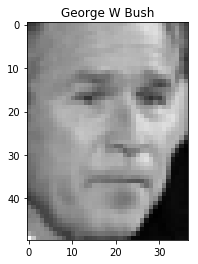

In [52]:
plt.imshow(data[0].reshape((50,37)),cmap='gray')
name = names[target[0]]
plt.title(name)

In [63]:
# 展示预测结果（把前100张预测数据的真实值和预测值一起展示）
true_test = data[1100:]
true_target = target[1100:]
predict_target = best_logistic.predict(X_test)

In [64]:
display(true_test.shape,true_target.shape,predict_target.shape)

(117, 1850)

(117,)

(117,)

In [79]:
names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

In [82]:
for i,name in enumerate(names):
    names[i] = name.split(' ')[-1]

In [83]:
names

array(['Sharon', 'Powell', 'Rumsfeld', 'Bush', 'Schroeder', 'Blair'],
      dtype='<U17')

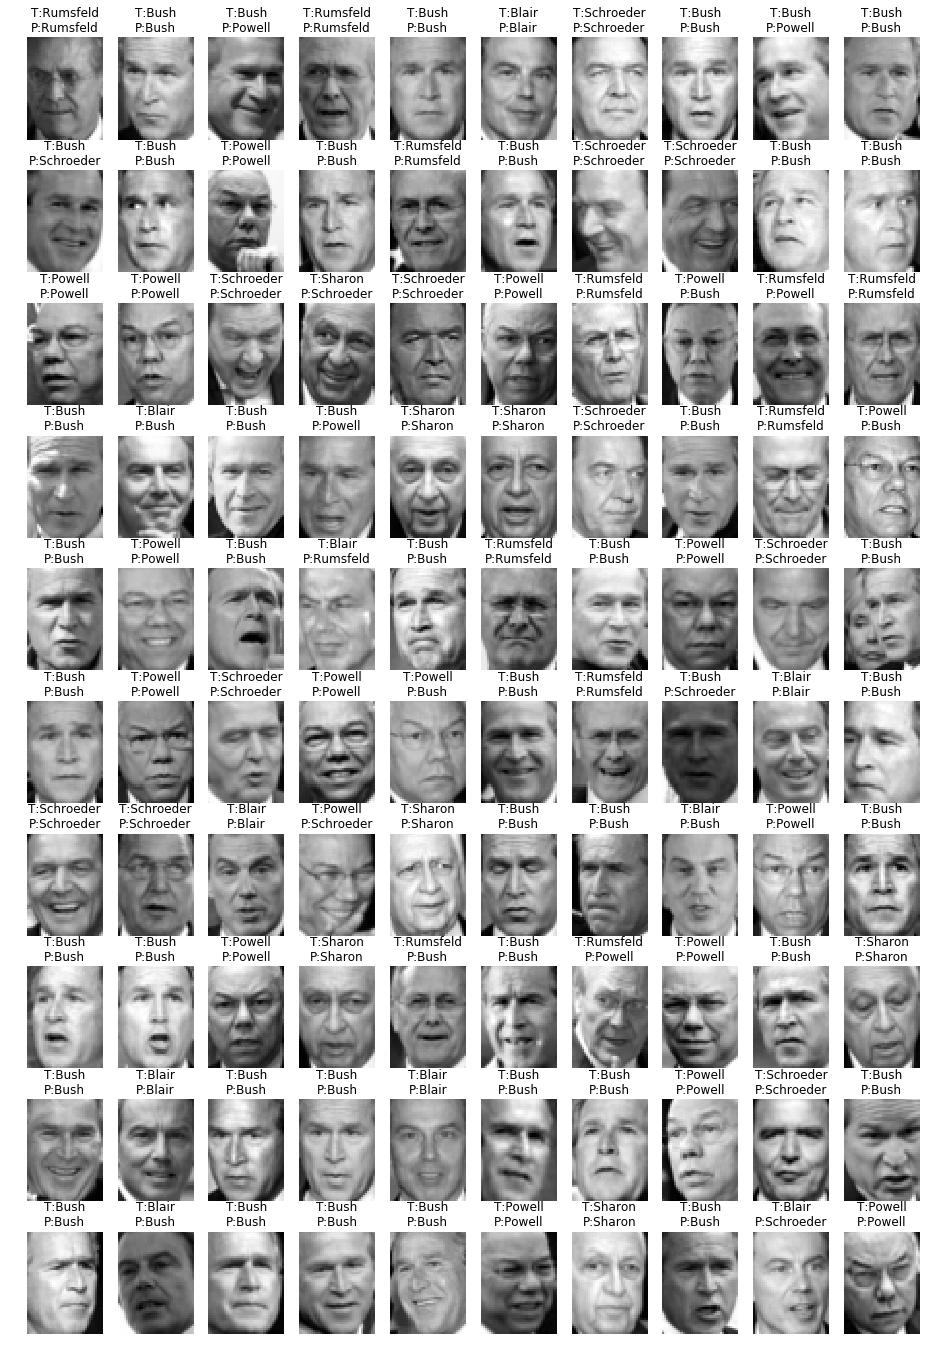

In [84]:
plt.figure(figsize=(16,24))
for i in range(100):
    axes = plt.subplot(10,10,i+1)
    data= true_test[i].reshape((50,37))
    plt.imshow(data,cmap='gray')
    pre_name = names[predict_target[i]]
    true_name = names[true_target[i]]
    title = 'T:'+true_name + '\nP:'+pre_name
    axes.set_title(title)
    axes.axis('off')

In [90]:
# 处理网络图片，查看预测结果
bush = plt.imread('bush.jpg')
bush = bush.max(axis=2)
bush.shape

(372, 514)

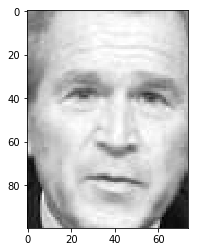

In [98]:
small_bush = bush[65:165,240:314]
plt.imshow(small_bush,cmap='gray')

C:\Users\ALIENWARE\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


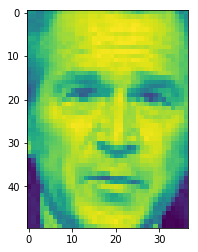

In [112]:
from skimage.transform import resize
# import scipy.misc as misc

resize_bush = resize(small_bush,(50,37))
plt.imshow(resize_bush)

In [115]:
bush_data = pca.transform(resize_bush.reshape(1,-1))

In [116]:
best_logistic.predict(bush_data)

array([1], dtype=int64)

In [117]:
names[1]

'Powell'

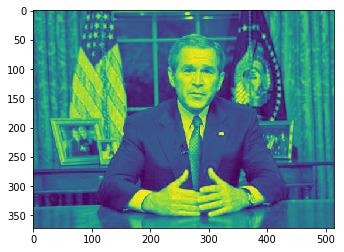

In [91]:
plt.imshow(bush)